# Going Deeper 2
## 없다면 우야 될까
|평가문항|상세기준|
|:---|:---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|


In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- main layer와 skip layer 총 2개를 구현해야함.
- skip layers는 stride가 1보다 큰 경우 필요. 입력 x와 출력의 크기가 다른 경우
- call() : input 을 main과 skip layers에 통과시킨 후 두 출력을 더해서 활성화 함수 적용

### ResNet 34

In [3]:
class ResidualBlock34(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation= "relu", **kwargs):
        super().__init__(**kwargs)
        self.activiation = keras.activations.get(activation)
         
        ## 34 main layer
        self.main_layers = [
            keras.layers.Conv2D(
                filters=filters,
                kernel_size=(3,3),
                strides = strides,
                padding='same',
            ),
            keras.layers.BatchNormalization(),
            self.activiation,
            keras.layers.Conv2D(
                filters=filters,
                kernel_size=(3,3),
                strides = 1,
                padding='same',
            ),
            keras.layers.BatchNormalization()
        ]
        
        ## 34 skip layers
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(
                    kernel_size=(1,1),
                    filters = filters,
                    strides = strides,
                    padding="same"
                ),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        ## main layer
        z = inputs
        for layer in self.main_layers:
            z = layer(z)
        
        ## skip layer
        skip_z = inputs
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
            
        return self.activiation(z + skip_z)

### ResNet 50

In [4]:
# The identity block
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    X_shortcut = X
    
    # 1 depth
    X = tf.keras.layers.Conv2D(
        filters=F1, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # 2 depth
    X = tf.keras.layers.Conv2D(
        filters=F2, 
        kernel_size=f, 
        strides=1, 
        padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # 3 depth
    X = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # add shortcut value and pass it through a ReLU activation
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X


In [5]:
# Convolutional Block
def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    X_shortcut = X
    
    # first step of main path
    X = tf.keras.layers.Conv2D(
        filters=F1, 
        kernel_size=1, 
        strides=s, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # second step of main path
    X = tf.keras.layers.Conv2D(
        filters=F2, 
        kernel_size=f, 
        strides=1, 
        padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # third step of main path
    X = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # shortcut path
    X_shortcut = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=s, 
        padding='valid')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add and pass it through a ReLU activation
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [6]:
# ResNet50
def ResNet50(input_shape=(32, 32, 3), classes=10):
    X_input = tf.keras.layers.Input(input_shape)
    # zero padding
    X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
    
    # stage 1
    X = tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=7, 
        strides=2, 
        name='conv1',
        )(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3,3), strides=2)(X)
    
    # stage 2
    X = convolutional_block(
        X, 
        f=3, 
        filters=[64,64,256]
        )
    X = identity_block(X, 3, [64,64,256])
    X = identity_block(X, 3, [64,64,256])
    
    # stage 3
    X = convolutional_block(
        X, 
        f = 3, 
        filters = [128, 128, 512], 
        )
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    # Stage 4
    X = convolutional_block(
        X, 
        f = 3, 
        filters = [256, 256, 1024], 
        )
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    # Stage 5
    X = convolutional_block(
        X, 
        f = 3, 
        filters = [512, 512, 2048], 
        )
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    # AVGPOOL
    # X = tf.keras.layers.AveragePooling2D()(X)
    X = tf.keras.layers.GlobalAvgPool2D()(X)
    
    
    # output layer
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax')(X)
    
    # Create Model
    model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model


### resnet을 구현하는 함수 build_resnet

In [7]:
def build_resnet(input_shape=(32, 32,3), is_50=False):
    if is_50:
        ## 50 cnn block 반복
        model = ResNet50(input_shape=input_shape)
    else:
        ## 채널 종류와 채널 갯수 
        num_of_channel = [3, 4, 6, 3]
        channel_list = [64, 128, 256, 512]


        model = keras.models.Sequential()
        ## 앞 부분 con layer와 pooling
        model.add(keras.layers.Conv2D(
                        input_shape=input_shape,
                        filters = 64,
                        kernel_size=(7,7),
                        strides = 2,
                        padding='same',
                    ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("relu"))
        model.add(keras.layers.MaxPool2D(
            pool_size=(3,3), 
            strides=2, 
            padding="same"))

        prev_filter = 64

        ## 34 cnn block 반복
        for (channel, num_channel) in zip(channel_list, num_of_channel):
            strides = 1 if channel == prev_filter else 2
            model.add(ResidualBlock34(filters = channel, strides= strides))
            prev_filter = channel
            
        ## 마지막 부분 layer
        model.add(keras.layers.GlobalAvgPool2D())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(10, activation="softmax"))
        
    
    return model

In [8]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
residual_block34 (ResidualBl (None, 8, 8, 64)          74368     
_________________________________________________________________
residual_block34_1 (Residual (None, 4, 4, 128)         231296    
_________________________________________________________________
residual_block34_2 (Residual (None, 2, 2, 256)         9

In [9]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

## 3) 일반 네트워크(plain network) 만들기


### plain block 34

In [10]:
class PlainBlock34(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation= "relu", **kwargs):
        super().__init__(**kwargs)
        self.activiation = keras.activations.get(activation)
         
        ## 34 main layer
        self.main_layers = [
            keras.layers.Conv2D(
                filters=filters,
                kernel_size=(3,3),
                strides = strides,
                padding='same',
            ),
            keras.layers.BatchNormalization(),
            self.activiation,
            keras.layers.Conv2D(
                filters=filters,
                kernel_size=(3,3),
                strides = 1,
                padding='same',
            ),
            keras.layers.BatchNormalization()
        ]
        
            
    def call(self, inputs):
        ## main layer
        z = inputs
        for layer in self.main_layers:
            z = layer(z)

        return self.activiation(z)

### plain block 50

In [11]:
# The identity block
def plain_identity_block(X, f, filters):
    F1, F2, F3 = filters
    X_shortcut = X
    
    # 1 depth
    X = tf.keras.layers.Conv2D(
        filters=F1, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # 2 depth
    X = tf.keras.layers.Conv2D(
        filters=F2, 
        kernel_size=f, 
        strides=1, 
        padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # 3 depth
    X = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # add shortcut value and pass it through a ReLU activation
    X = tf.keras.layers.Activation('relu')(X)
    
    return X


In [12]:
# Convolutional Block
def plain_convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    X_shortcut = X
    
    # first step of main path
    X = tf.keras.layers.Conv2D(
        filters=F1, 
        kernel_size=1, 
        strides=s, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # second step of main path
    X = tf.keras.layers.Conv2D(
        filters=F2, 
        kernel_size=f, 
        strides=1, 
        padding='same')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # third step of main path
    X = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=1, 
        padding='valid')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # shortcut path
    X_shortcut = tf.keras.layers.Conv2D(
        filters=F3, 
        kernel_size=1, 
        strides=s, 
        padding='valid')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add and pass it through a ReLU activation
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [13]:
# ResNet50
def Plain_ResNet50(input_shape=(32, 32, 3), classes=10):
    X_input = tf.keras.layers.Input(input_shape)
    # zero padding
    X = tf.keras.layers.ZeroPadding2D((3,3))(X_input)
    
    # stage 1
    X = tf.keras.layers.Conv2D(
        filters=64, 
        kernel_size=7, 
        strides=2, 
        name='conv1',
        )(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3,3), strides=2)(X)
    
    # stage 2
    X = plain_convolutional_block(
        X, 
        f=3, 
        filters=[64,64,256]
        )
    X = plain_identity_block(X, 3, [64,64,256])
    X = plain_identity_block(X, 3, [64,64,256])
    
    # stage 3
    X = plain_convolutional_block(
        X, 
        f = 3, 
        filters = [128, 128, 512], 
        )
    X = plain_identity_block(X, 3, [128, 128, 512])
    X = plain_identity_block(X, 3, [128, 128, 512])
    X = plain_identity_block(X, 3, [128, 128, 512])
    
    # Stage 4
    X = plain_convolutional_block(
        X, 
        f = 3, 
        filters = [256, 256, 1024], 
        )
    X = plain_identity_block(X, 3, [256, 256, 1024])
    X = plain_identity_block(X, 3, [256, 256, 1024])
    X = plain_identity_block(X, 3, [256, 256, 1024])
    X = plain_identity_block(X, 3, [256, 256, 1024])
    X = plain_identity_block(X, 3, [256, 256, 1024])
    
    # Stage 5
    X = plain_convolutional_block(
        X, 
        f = 3, 
        filters = [512, 512, 2048], 
        )
    X = plain_identity_block(X, 3, [512, 512, 2048])
    X = plain_identity_block(X, 3, [512, 512, 2048])
    
    # AVGPOOL
    # X = tf.keras.layers.AveragePooling2D()(X)
    X = tf.keras.layers.GlobalAvgPool2D()(X)
    
    
    # output layer
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(classes, activation='softmax')(X)
    
    # Create Model
    model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model


### plain net을 생성하는 build_plainnet 구현

In [14]:
def build_plainnet(input_shape=(224, 224, 3), is_50=False):
    if is_50:
        ## 50 cnn block
        model = Plain_ResNet50(input_shape=input_shape)
        
    else:
        ## 34 cnn block
        ## 채널 종류와 채널 갯수 
        num_of_channel = [3, 4, 6, 3]
        channel_list = [64, 128, 256, 512]


        model = keras.models.Sequential()
        ## 앞 부분 con layer와 pooling
        model.add(keras.layers.Conv2D(
                        input_shape=input_shape,
                        filters = 64,
                        kernel_size=(7,7),
                        strides = 2,
                        padding='same',
                    ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("relu"))
        model.add(keras.layers.MaxPool2D(
            pool_size=(3,3), 
            strides=2, 
            padding="same"))

        prev_filter = 64
        
        ##  반복
        for (channel, num_channel) in zip(channel_list, num_of_channel):
            strides = 1 if channel == prev_filter else 2
            model.add(PlainBlock34(filters = channel, strides= strides))
            prev_filter = channel
            
        ## 마지막 부분 layer
        model.add(keras.layers.GlobalAvgPool2D())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(10, activation="softmax"))

    
    return model

In [15]:
plain_resnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False)
plain_resnet_34.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_65 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_50 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
plain_block34 (PlainBlock34) (None, 56, 56, 64)        74368     
_________________________________________________________________
plain_block34_1 (PlainBlock3 (None, 28, 28, 128)       222464    
_________________________________________________________________
plain_block34_2 (PlainBlock3 (None, 14, 14, 256)      

In [16]:
plain_resnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True)
plain_resnet_50.summary()

Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 230, 230, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_74 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_51 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 28, 28, 64)        416

## 4)  resnet 50 vs plain 50,  resnet 34 vs plain 34

In [33]:
BATCH_SIZE = 256
EPOCH = 20

In [31]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [32]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

cifar10 dataset불러오기

In [35]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


### 34 비교하기

In [41]:
plain_resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

plain_history_34 = plain_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


195/195 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9991WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='conv2d_64_input'), name='conv2d_64_input', description="created by layer 'conv2d_64_input'"), but it was called on an input with incompatible shape (None, 32, 32, 3).


195/195 [==============================] - 20s 78ms/step - loss: 0.0321 - accuracy: 0.9991 - val_loss: 1.8897 - val_accuracy: 0.5528
Epoch 2/20
195/195 [==============================] - 15s 76ms/step - loss: 0.0250 - accuracy: 0.9999 - val_loss: 2.0659 - val_accuracy: 0.5399
Epoch 3/20
195/195 [==============================] - 15s 76ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 2.0680 - val_accuracy: 0.5542
Epoch 4/20
195/195 [==============================] - 15s 76ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 2.0572 - val_accuracy: 0.5502
Epoch 5/20
195/195 [==============================] - 15s 76ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 2.1045 - val_accuracy: 0.5472
Epoch 6/20
195/195 [==============================] - 15s 77ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 2.0797 - val_accuracy: 0.5518
Epoch 7/20
195/195 [==============================] - 15s 77ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 2.1270 - val_accuracy: 0.5463
Epo

In [40]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
195/195 [==============================] - 26s 108ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.8966 - val_accuracy: 0.6048
Epoch 2/20
195/195 [==============================] - 16s 83ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.9230 - val_accuracy: 0.6091
Epoch 3/20
195/195 [==============================] - 16s 83ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.9509 - val_accuracy: 0.6090
Epoch 4/20
195/195 [==============================] - 16s 84ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.9337 - val_accuracy: 0.6125
Epoch 5/20
195/195 [==============================] - 16s 84ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.9315 - val_accuracy: 0.6146
Epoch 6/20
195/195 [==============================] - 16s 84ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 2.0121 - val_accuracy: 0.6029
Epoch 7/20
195/195 [==============================] - 16s 84ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 2.0091 - val_accuracy

34 시각화

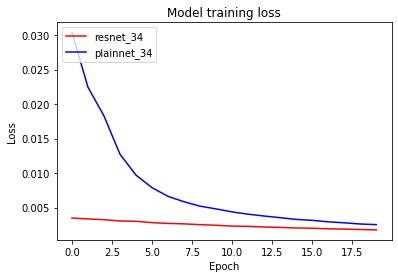

In [42]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(plain_history_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plainnet_34'], loc='upper left')
plt.show()

resnet으로 학습한 결과는 처음부터 loss가 작았으며 epoch수가 증가할 수록 아주 미미하게 loss가 줄어드는 것을 볼 수 있다.  
반면에 residual block을 제거한 plain net 은 loss가 0.03부터 시작하다 epoch이 늘어날수록 loss가 초반에 급격히 줄다가 천천히 줄어드는 모습을 볼 수 있다.   
여기서 알 수 있는 것은,  resnet 논문 저자들의 말대로 layer가 깊다고 무조건 좋은 것은 아니라는 것이 증명 되었다.